In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

В этом задании Вам необходимо предсказать **является ли абонент мультисимером** (имеет 2+ СИМ-карты). 


### Задание

Проведите преодобработку и анализ фичей, постройте модель бинарной классификации, оцените ее точность, обоснуйте выбор метрики и не забудьте сделать предсказания для абонентов, у которых поле **'target'** содержит значение **'NaN'**.

**1. Считайте датасет и проведите первичный анализ**

*Описание полей, как и сам датасет. доступны внутри файла multisim_dataset*

In [3]:
# читаем данные из excel файла
raw_data = pd.read_excel('multisim_dataset.xlsx',sheetname='data')

In [4]:
# смотрим первые строчки
raw_data.head()

id  mg_traffic_in  tp_code  num_voice_out tp_change_date  uniq_calls_cnt  \
0  101           2.98      1.0           17.0            NaT              53   
1  102           1.82      2.0           97.0            NaT              82   
2  103           0.00      3.0           22.0            NaT              58   
3  104           0.00      4.0           30.0            NaT              61   
4  105           0.80      5.0           29.0            NaT              49   

   age_cat  tech_sms_cnt_3m  tech_sms_cnt_6m  called_ctn_all_group   ...    \
0        4            657.0           1917.0                   0.0   ...     
1        5              0.0             22.0                   5.0   ...     
2        3            162.0            246.0                   0.0   ...     
3       10              NaN              NaN                   0.0   ...     
4        0             66.0            130.0                   1.0   ...     

   complex_value_size  imei_cnt main_balance_adjust_minus_cnt  state_code  \
0            4.666667       1.0                           NaN         AST   
1            1.666667       1.0                           NaN         ORB   
2            1.000000       1.0                           NaN         VIP   
3            2.666667       1.0                           NaN         KCH   
4            1.000000       1.0                      1.333333         STV   

   macro_state  time_onnet  sum_recharges_3m  year month  target  
0            1        3977            809.00  2019     1     NaN  
1            1        1617            622.00  2019     1     NaN  
2            1        2703            366.04  2019     1     1.0  
3            1        1153           1122.58  2019     1     1.0  
4            1        2174            633.20  2019     1     0.0  

[5 rows x 25 columns]

In [5]:
# смотрим на структуру данных
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 25 columns):
id                               90000 non-null int64
mg_traffic_in                    90000 non-null float64
tp_code                          60347 non-null float64
num_voice_out                    30000 non-null float64
tp_change_date                   30000 non-null datetime64[ns]
uniq_calls_cnt                   90000 non-null int64
age_cat                          90000 non-null int64
tech_sms_cnt_3m                  61695 non-null float64
tech_sms_cnt_6m                  61695 non-null float64
called_ctn_all_group             89916 non-null float64
device_cost                      88035 non-null float64
traf_kb                          90000 non-null int64
sim_type                         88446 non-null object
gender_male_prob                 90000 non-null float64
complex_value_sum                89946 non-null float64
complex_value_size               89946 non-null float

<font color ='blue'>Часть признаков имеет пропущенные значения, для начала заполним их нулями</font>

In [6]:
# извлечем из датасета тестовые данные
train_data = raw_data[raw_data['target'].notnull()]
test_data = raw_data[raw_data['target'].isnull()]

In [7]:
print('train data shape ={}, test data shape = {}'.format(train_data.shape,test_data.shape))

train data shape =(73249, 25), test data shape = (16751, 25)


In [8]:
# удалим столбцы id,tp_change_date
train_data.drop(['id','tp_change_date'],axis=1,inplace=True)
test_data.drop(['id','tp_change_date'],axis=1,inplace=True)

In [9]:
print('train data shape ={}, test data shape = {}'.format(train_data.shape,test_data.shape))

train data shape =(73249, 23), test data shape = (16751, 23)


In [10]:
# переведем в один тип
train_data['sim_type'] = train_data['sim_type'].astype('str')
test_data['sim_type'] = test_data['sim_type'].astype('str')

In [11]:
train_data_le = train_data.copy()
test_data_le = test_data.copy()

In [12]:
# категориальные признаки закодируем, используя label encoding
le = preprocessing.LabelEncoder()
train_data_le['sim_type'] = pd.Series(le.fit_transform(train_data_le['sim_type']))
train_data_le['state_code'] = pd.Series(le.fit_transform(train_data_le['state_code']))
test_data_le['sim_type'] = pd.Series(le.fit_transform(test_data_le['sim_type']))
test_data_le['state_code'] = pd.Series(le.fit_transform(test_data_le['state_code']))

In [13]:
# заполняем пропущенные значения
train_data_le.fillna(0,inplace=True)
test_data_le.fillna(0,inplace=True)

In [14]:
X,y = train_data_le.drop('target',axis =1).values, train_data_le['target'].values

In [15]:
# Выделим 10% данных для валидации
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, random_state=2019)

In [16]:
print(X_train.shape,X_valid.shape)

(65924, 22) (7325, 22)


In [17]:
# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

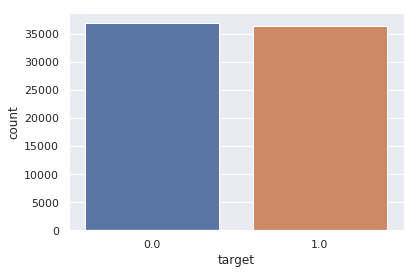

In [18]:
# Распределение целевой переменной
sns.countplot(y);
plt.xlabel('target');

<font color ='blue'>Выборка практически идеально сбалансирована, поэтому можно применить метрику acuracy</font>

**2. Постройте простейшую модель (*baseline*) и сделайте выводы**

*Можно использовать любые модели*

In [19]:
%%time
# Для начала используем случайный лес, поскольку линейные модели плохо работают на неотмасштабированных данных
rf_base = RandomForestClassifier()
rf_base.fit(X_train,y_train)

CPU times: user 1.22 s, sys: 173 µs, total: 1.22 s
Wall time: 1.21 s


In [20]:
y_pred = rf_base.predict(X_valid)
accuracy_score(y_pred,y_valid)

0.9645051194539249

<font color ='blue'>Неплохое качество, скорее всего какие-то признаки очень хорошо коррелируют с целевой меткой</font>

**3. Визуализируйте значения фичей в зависимости от таргета или других фич**

*Интерпретируйте полученные результаты*

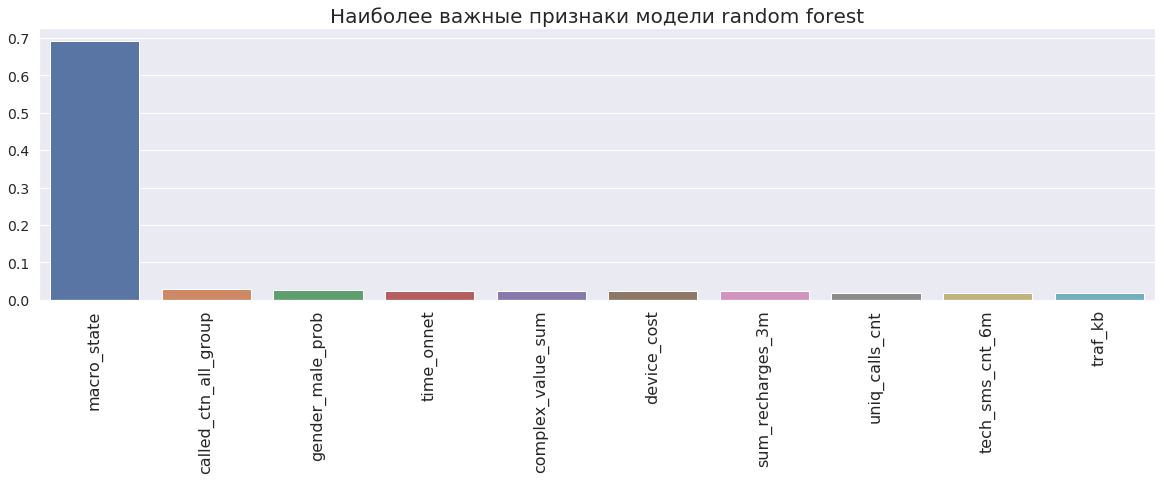

In [21]:
importances = rf_base.feature_importances_
idx = np.argsort(importances)[::-1][0:10]
feature_names = train_data.columns.values

plt.figure(figsize=(20,5))
sns.barplot(x=feature_names[idx], y=importances[idx]);
plt.title("Наиболее важные признаки модели random forest",fontsize=20);
plt.xticks(fontsize=16,rotation=90);
plt.yticks(fontsize=14);

In [22]:
# посмотрим на отобранные признаки
top = train_data_le.loc[:, feature_names[idx]]

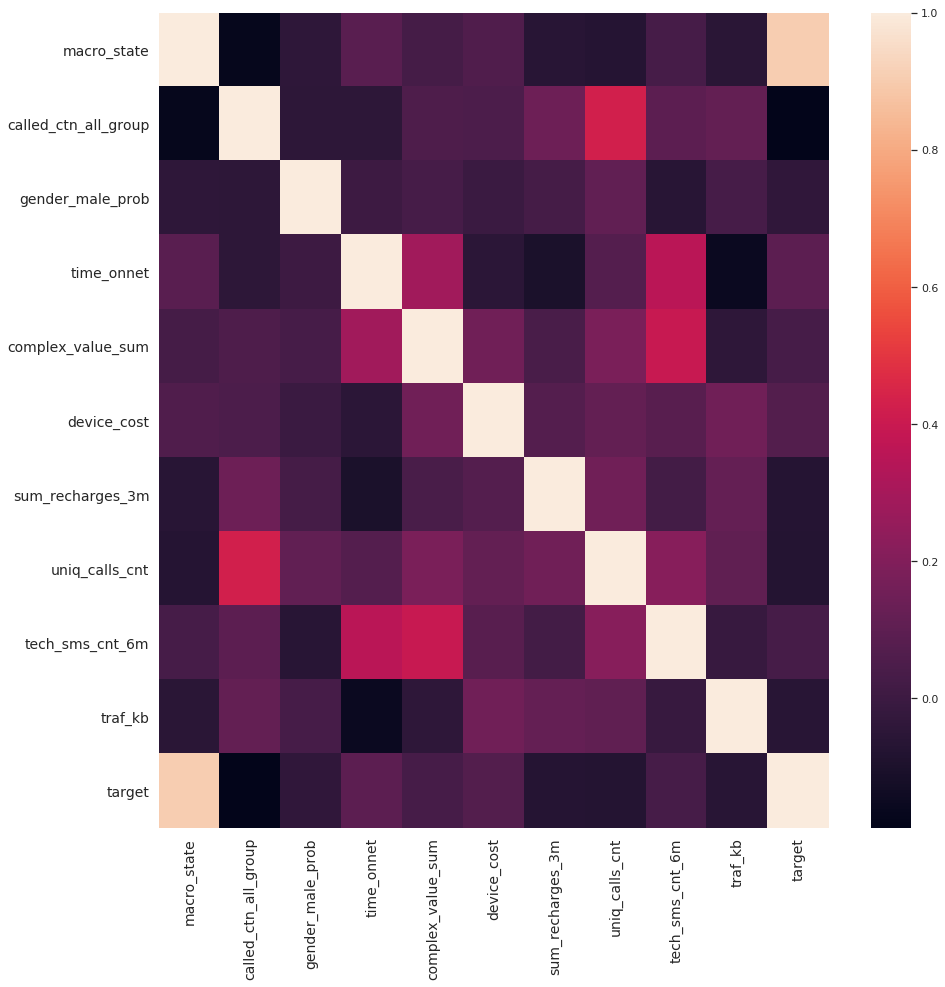

In [23]:
# Построим тепловую карту
top_with_target = pd.concat([top, train_data['target']], axis=1)
corr = top_with_target.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

<font color ='blue'>Действительно, признак macro_state практически идеально коррелирует с таргетом</font>

Теперь попробуем обработать данные, чтобы улучшить показатель безлайна

In [24]:
# выделим признаки в отдельные группы
numeric = ['mg_traffic_in','num_voice_out','uniq_calls_cnt','tech_sms_cnt_3m',
                   'tech_sms_cnt_6m','device_cost',                   
                   'traf_kb','gender_male_prob',
                   'complex_value_sum',
                   'complex_value_size',
                   'imei_cnt','main_balance_adjust_minus_cnt',
                   'time_onnet','sum_recharges_3m'
]
categorical = ['tp_code','age_cat','called_ctn_all_group','sim_type','state_code',
                       'macro_state','year','month'
                       
]

In [25]:
print('numeric={},categorical={}'.format(len(numeric),len(categorical)))    

numeric=14,categorical=8


In [26]:
n_num = len(numeric)

In [27]:
train_data[numeric].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73249 entries, 2 to 89999
Data columns (total 14 columns):
mg_traffic_in                    73249 non-null float64
num_voice_out                    24223 non-null float64
uniq_calls_cnt                   73249 non-null int64
tech_sms_cnt_3m                  50196 non-null float64
tech_sms_cnt_6m                  50196 non-null float64
device_cost                      71627 non-null float64
traf_kb                          73249 non-null int64
gender_male_prob                 73249 non-null float64
complex_value_sum                73205 non-null float64
complex_value_size               73205 non-null float64
imei_cnt                         72865 non-null float64
main_balance_adjust_minus_cnt    25579 non-null float64
time_onnet                       73249 non-null int64
sum_recharges_3m                 73249 non-null float64
dtypes: float64(11), int64(3)
memory usage: 8.4 MB


In [28]:
# заполним теперь пропуски средними значениями в численных переменных
train_data[numeric] = train_data[numeric].fillna(train_data[numeric].mean())
test_data[numeric] = test_data[numeric].fillna(test_data[numeric].mean())

In [29]:
# посмотрим на распределения численных признаков
fig, ax = plt.subplots(n_num,2, figsize =(20,7*n_num))
for i in range(n_num):
    sns.distplot(train_data[numeric[i]],ax =ax[i,0]);
    ax[0,0].set_title('train',size=18);
    sns.distplot(test_data[numeric[i]],ax =ax[i,1]);
    ax[0,1].set_title('test',size=18);

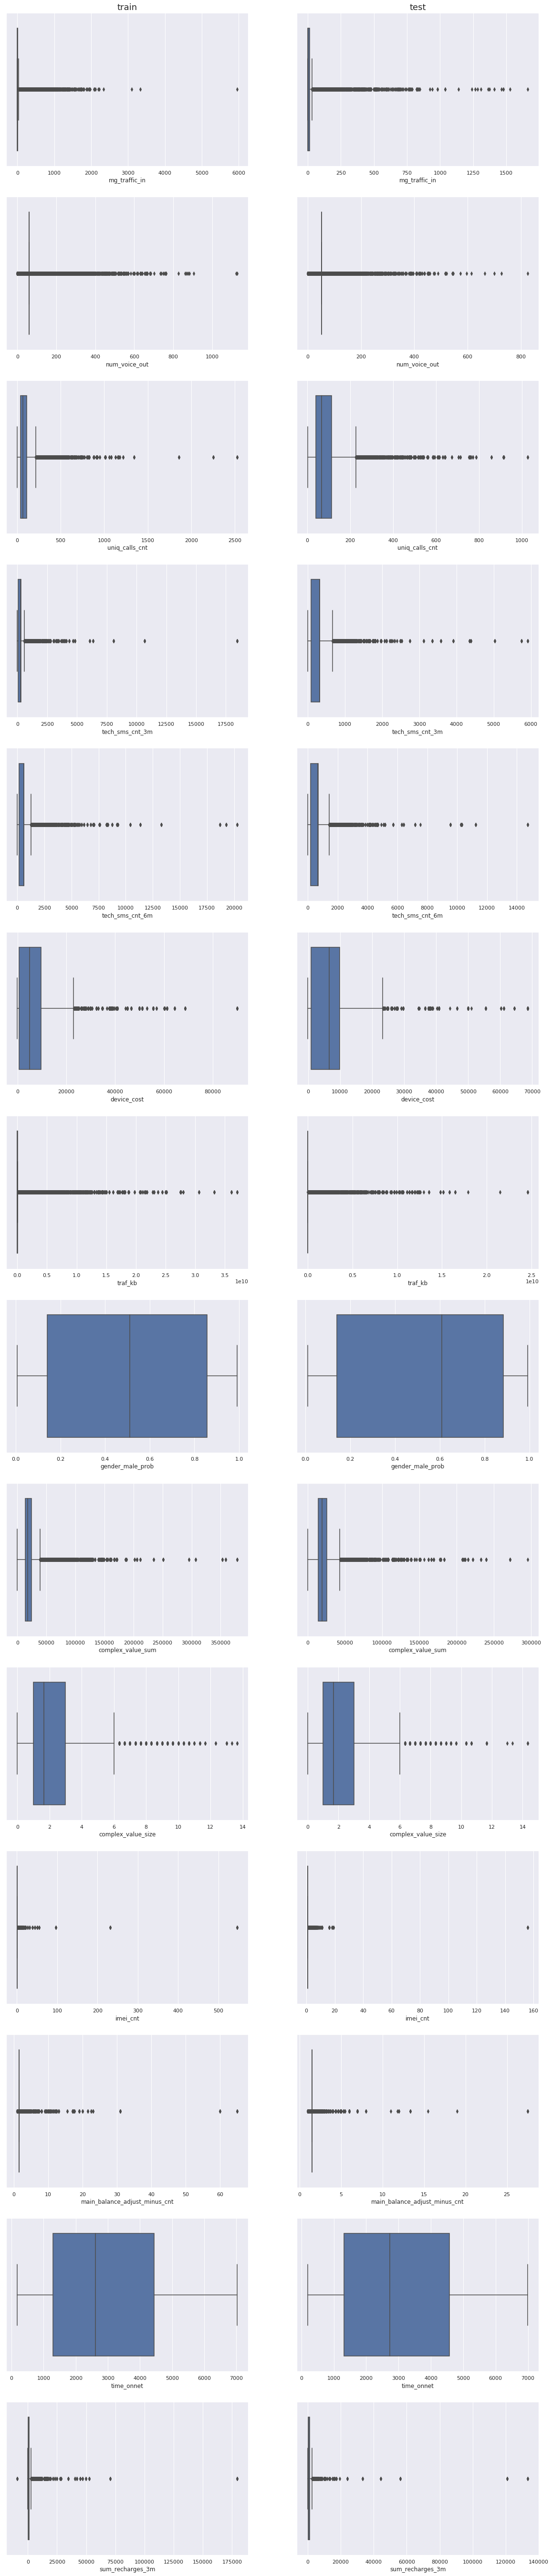

In [30]:
fig, ax = plt.subplots(n_num,2, figsize =(20,7*n_num))
for i in range(n_num):
    sns.boxplot(train_data[numeric[i]],ax =ax[i,0]);
    ax[0,0].set_title('train',size=18);
    sns.boxplot(test_data[numeric[i]],ax =ax[i,1]);
    ax[0,1].set_title('test',size=18);

<font color ='blue'>Мы видим, что распределение большинства признаков далеки от нормальных, поскольку имеют длинные хвосты  и повторяющиеся значения</font>

In [31]:
# посмотрим на mg_traffic_in  
train_data[numeric[0]].value_counts().iloc[:10]

0.00    15118
0.17      431
0.02      412
0.18      321
0.15      314
0.20      281
0.52      261
0.25      245
0.23      240
0.22      220
Name: mg_traffic_in, dtype: int64

In [32]:
# применим логарифмическое шкалирование для этого признака
train_data[numeric[0]] = np.log1p(train_data[numeric[0]].values)
test_data[numeric[0]] = np.log1p(test_data[numeric[0]].values)

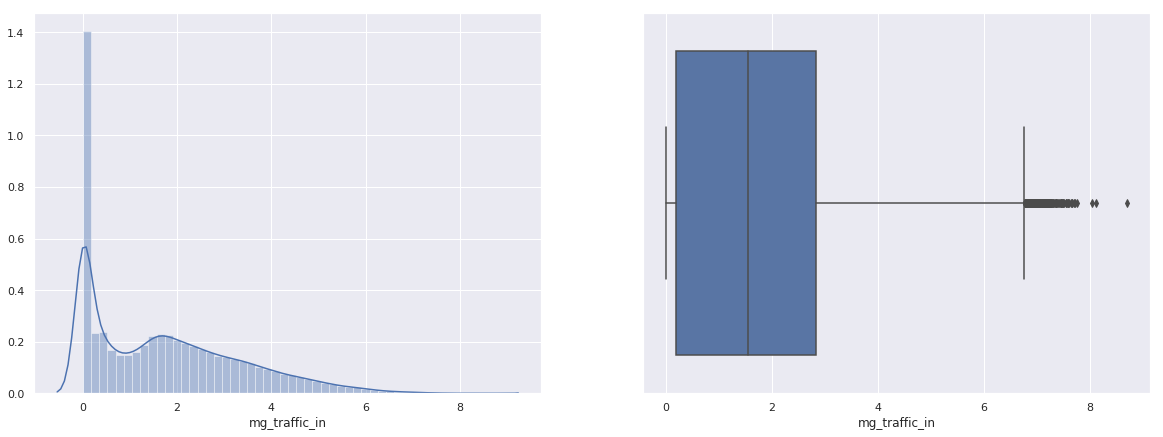

In [33]:
# Распределение теперь ближе к нормальному
fig,ax = plt.subplots(1,2,figsize=(20,7))
sns.distplot(train_data[numeric[0]],ax=ax[0]);
sns.boxplot(train_data[numeric[0]],ax=ax[1]);

<font color ='blue'>Распределение стало ближе к нормальному, заведем отдельный категориальный признак на основе данного, который будет отражать интенсивность трафика </font>

In [34]:
tr_min = train_data[numeric[0]][train_data[numeric[0]]!=0].min()
ts_min = test_data[numeric[0]][test_data[numeric[0]]!=0].min()
tr_max = train_data[numeric[0]].max()
ts_max = test_data[numeric[0]].max()
print(tr_min,ts_min,tr_max,ts_max)

0.019802627296179712 0.019802627296179712 8.693726361107908 7.4166009439226634


In [35]:
train_data['mg_traffic_in_cat'] = np.digitize( train_data[numeric[0]].values,
                                              bins=[0,tr_min,6,tr_max])
test_data['mg_traffic_in_cat'] = np.digitize( test_data[numeric[0]].values,
                                              bins=[0,ts_min,6,ts_max])

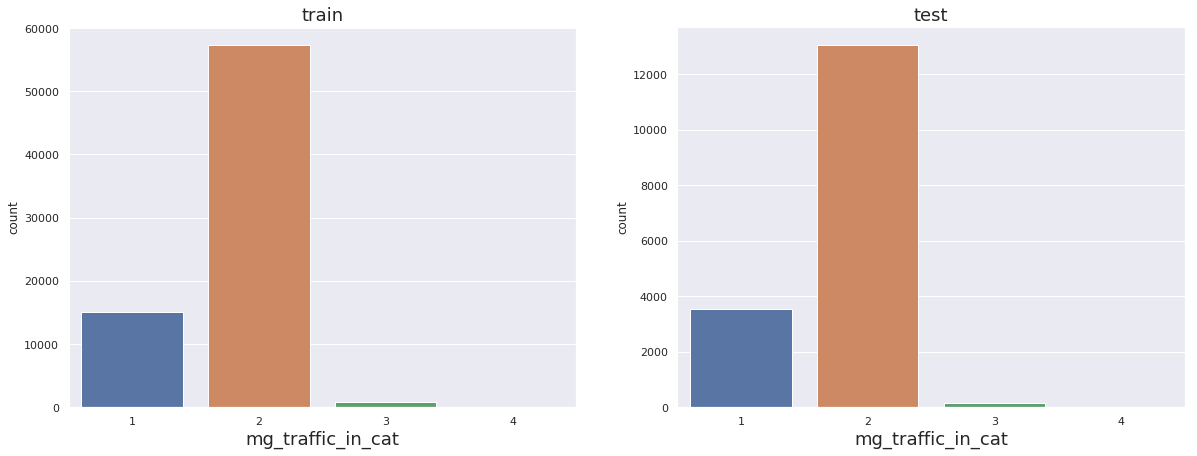

In [36]:
# посмотрим на полученные значения
fig,ax = plt.subplots(1,2,figsize=(20,7))
sns.countplot(train_data['mg_traffic_in_cat'],ax=ax[0,],);
ax[0].set_title('train',size=18);
ax[0].set_xlabel('mg_traffic_in_cat',size=18);
sns.countplot(test_data['mg_traffic_in_cat'],ax=ax[1]);
ax[1].set_title('test',size=18);
ax[1].set_xlabel('mg_traffic_in_cat',size=18);

Применим аналогичный прием для признаков:

- uniq_calls_cnt
- tech_sms_cnt_3m  
- tech_sms_cnt_6m
- device_cost  
- traf_kb  
- complex_value_sum
- complex_value_size
- imei_cnt
- main_balance_adjust_minus_cnt
- sum_recharges_3m

Также вызывает подозрение признак device_cost 

In [37]:
train_data['device_cost'].value_counts().iloc[:10]

-1.000000        17873
 6621.000000      1757
 6154.845254      1622
 8194.000000      1237
 9628.000000      1031
 7950.000000       855
 4955.000000       790
 10633.000000      777
 10990.000000      690
 7490.000000       681
Name: device_cost, dtype: int64

In [38]:
test_data['device_cost'].value_counts().iloc[:10]

-1.000000        3913
 6621.000000      424
 6918.672172      343
 8194.000000      317
 9628.000000      289
 10633.000000     201
 7950.000000      195
 9957.000000      186
 8990.000000      186
 19479.000000     175
Name: device_cost, dtype: int64

In [39]:
# заменим -1 на среднее значение признака
dev_cost_mean = train_data['device_cost'][train_data['device_cost'] != -1].mean()
train_data['device_cost'] = train_data['device_cost'].map(lambda x: int(dev_cost_mean)  if x== -1 else x)

In [40]:
dev_cost_mean_t = test_data['device_cost'][test_data['device_cost'] != -1].mean()
test_data['device_cost'] = test_data['device_cost'].map(lambda x: int(dev_cost_mean_t)  if x== -1 else x)

In [41]:
# sum_recharges_3m
rech_mean = train_data['sum_recharges_3m'][train_data['sum_recharges_3m'] > 0].mean()
train_data['sum_recharges_3m'] = train_data['sum_recharges_3m'].map(lambda x: rech_mean  if x<0 else x)

In [42]:
# теперь применим логарифмирование
ftc_log_sc = ['uniq_calls_cnt','num_voice_out','tech_sms_cnt_3m','tech_sms_cnt_6m','device_cost',
              'traf_kb','complex_value_sum','complex_value_size','imei_cnt',
'main_balance_adjust_minus_cnt','sum_recharges_3m'
]
for ftc in  ftc_log_sc:
    train_data[ftc] = np.log1p(train_data[ftc].values)
    test_data[ftc] = np.log1p(test_data[ftc].values)

In [43]:
# поправим device_cost
dev_cost_1 = train_data['device_cost'][train_data['device_cost'].notnull()].mean()
train_data['device_cost'].fillna(dev_cost_1,inplace=True)
dev_cost_2 = test_data['device_cost'][test_data['device_cost'].notnull()].mean()
test_data['device_cost'].fillna(dev_cost_2,inplace=True)

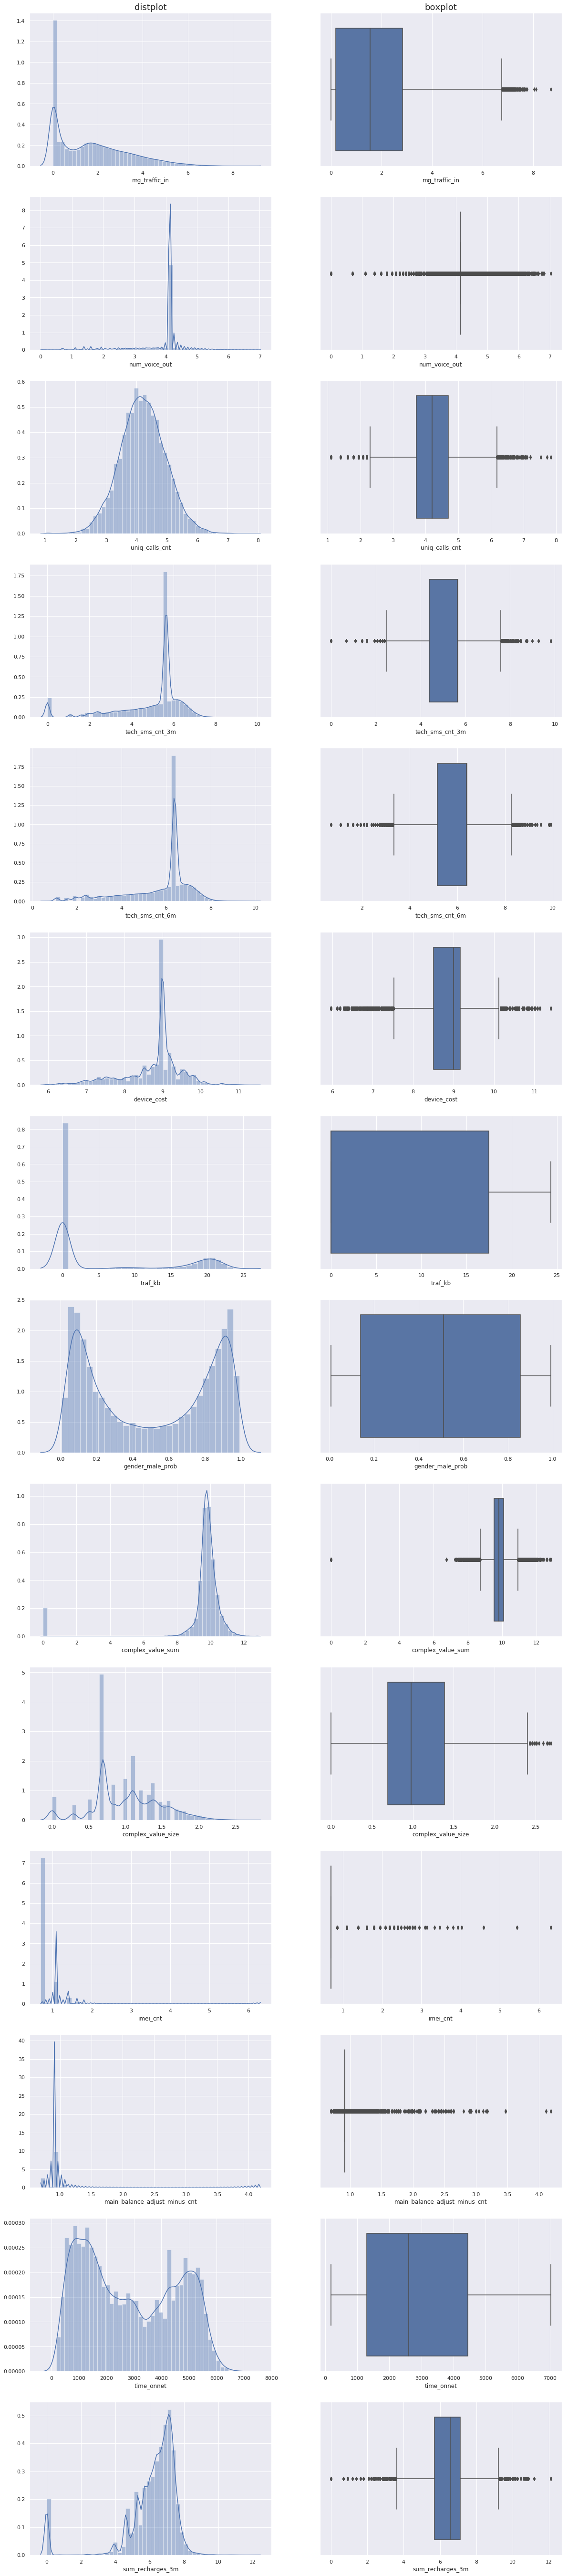

In [44]:
# Строим распределения после обработки
fig, ax = plt.subplots(n_num,2, figsize =(20,7*n_num))
for i in range(len(numeric)):
    sns.distplot(train_data[numeric[i]],ax =ax[i,0]);
    ax[0,0].set_title('distplot',size=18);
    sns.boxplot(train_data[numeric[i]],ax =ax[i,1]);
    ax[0,1].set_title('boxplot',size=18);

In [45]:
# применим шкалирование для time_onnet
t_on_mean = train_data['time_onnet'].mean()
t_on_std = train_data['time_onnet'].std()
t_on_mean_t = test_data['time_onnet'].mean()
t_on_std_t = test_data['time_onnet'].std()
train_data['time_onnet']=(train_data['time_onnet'].values-t_on_mean)/t_on_std
test_data['time_onnet']=(test_data['time_onnet'].values-t_on_mean_t)/t_on_std_t

In [46]:
# посмотрим на распределение категориальных признаков
train_data[categorical].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73249 entries, 2 to 89999
Data columns (total 8 columns):
tp_code                 49439 non-null float64
age_cat                 73249 non-null int64
called_ctn_all_group    73173 non-null float64
sim_type                73249 non-null object
state_code              73249 non-null object
macro_state             73249 non-null int64
year                    73249 non-null int64
month                   73249 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 7.5+ MB


In [47]:
train_data[categorical] = train_data[categorical].fillna('na')
test_data[categorical] = test_data[categorical].fillna('na')

In [48]:
# кодируем категориальные признаки в one_hot
train_dummies = pd.get_dummies(train_data,columns=categorical[1:])
test_dummies = pd.get_dummies(test_data,columns=categorical[1:])

In [49]:
# делаем backup датасетов
train_dummies.to_csv('train_data.csv',index=False)
test_dummies.to_csv('test_data.csv',index=False)

In [50]:
X_final, y_final = train_dummies.drop('target',axis =1), train_dummies['target']

In [51]:
X_final['tp_code'] = X_final['tp_code'].map(lambda x: 0  if x =='na' else x)

In [52]:
print(X_final.shape)

(73249, 150)


In [53]:
# Выделим часть датасета под валидацию
X_train, X_valid, y_train, y_valid = train_test_split(
    X_final.values, y_final.values, test_size=0.1, random_state=2019)

In [54]:
print(X_train.shape, X_valid.shape)

(65924, 150) (7325, 150)


**4. Постройте модель с учетом прошлых пунктов**

In [55]:
# попробуем также нелинейную модель без настройки

In [56]:
%%time
rf = RandomForestClassifier()
rf.fit(X_train,y_train) 

CPU times: user 1.18 s, sys: 9.83 ms, total: 1.19 s
Wall time: 1.19 s


In [57]:
y_pred_rf = rf.predict(X_valid)
accuracy_score(y_pred_rf,y_valid)

0.964778156996587

In [58]:
# теперь попробуем улучшить модель с помощью настройки гиперпараметров
from sklearn.model_selection import GridSearchCV

In [59]:
%%time
rf = RandomForestClassifier(random_state=2019)
param_grid = { 
    'n_estimators': [100,200,500],
    'max_depth' : [2,4,6,8],
}
rf_cv = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5,n_jobs=-1)
rf_cv.fit(X_train,y_train)

CPU times: user 14.8 s, sys: 671 ms, total: 15.5 s
Wall time: 1min 30s


In [60]:
y_pred_rf = rf_cv.predict(X_valid)
accuracy_score(y_pred_rf,y_valid)

0.9463481228668942

In [61]:
rf_cv.best_params_

{'max_depth': 2, 'n_estimators': 100}

*Не забудьте про валидацию и оптимизацию гиперпараметров*

In [62]:
# Попробуем также модель градиентного бустинга
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

from sklearn.model_selection import cross_val_score,StratifiedKFold

import xgboost as xgb

In [69]:
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    
    clf =xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        n_jobs=4,
        **params
    )
    score = cross_val_score(clf, X_valid, y_valid, cv=StratifiedKFold()).mean()
    print('accuracy {:.3f} params {}'.format(score, params))
    return score
space = {
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

TypeError: 'generator' object is not subscriptable

**5. Сделайте предсказания и выведите значения метрик (самостоятельно написав основные функции, например, через confusion matrix)**

In [64]:
def accuracy(cnf_matrix):
    tn, fp, fn, tp = cnf_matrix.ravel()
    acc = (tp+tn)/(tn+fp+fn+tp)
    return acc

def recall(cnf_matrix):
    tn, fp, fn, tp = cnf_matrix.ravel()
    rcl = tp/(tp+fn)
    return rcl

In [65]:
from sklearn.metrics import confusion_matrix

In [66]:
cnf_matrix = confusion_matrix(y_pred_rf,y_valid)

In [67]:
accuracy(cnf_matrix)

0.9463481228668942

In [68]:
recall(cnf_matrix)

0.9954586739327884

### best score 0.968

**6. Опишите следующие шаги, которые Вы бы решили делать в следующих итерациях проекта**

- 1. Провести более глубокий анализ зависимостей в признаках
- 2. Генерация новых признаков
- 3. Подбор гипермараметров моделей